# Capstone Project
## Author - Catalina Ifrim

In [ ]:
"""
UW DATASCI420-Machine Learning Techniques
Milestone3-Capstone_Final_Project

"""

### Instructions

Milestone 3 continues your work with the diaper manufacturing problem, using the same datasets:
- a dataset file **SECOM** containing **1567 examples**, each with **591 features**, presented in a 1567 x 591 matrix
- a labels file listing the classifications and date time stamp for each example

Create a new notebook and perform each of the following tasks and answer the related questions:

1. **Build a simple neural networks model**
2. **Build a DNN model**
3. **Build a RNN model**
4. Summarize your findings with examples.  Explain what the manufacturer should focus on to optimize the diaper manufacturing
process.
5. Solicit specific feedback on your code 

### Dataset Description

The SECOM dataset is located at https://archive.ics.uci.edu/ml/machine-learning-databases/secom/ and consists of two files:
- a dataset file SECOM containing 1567 examples, each with 591 features, presented in a 1567 x 591 matrix
- a labels file listing the classifications and date time stamp for each example


A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of 
signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally 
valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant 
information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically 
have a much larger number of signals than are actually required.

The dataset presented in this case represents a selection of such features where each example represents a single production 
entity with associated measured features. The labels represent a simple pass/fail yield for in house line testing and 
associated date time stamp. For the labels, –1 corresponds to a Pass and 1 corresponds to a Fail and the data time stamp is 
for that specific test point.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM

%matplotlib inline

### Read and merge data

In [2]:
# Load dataset

# Read the secom_data dataset as pandas dataframe and give names to the columns
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
names = ["Signal" + str(x) for x in range(0, 590)]
secom_var = pd.read_csv(url, sep=" ", names=names, na_values = "NaN")

# Read the secom_labels dataset as pandas dataframe
url_l = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url_l,sep=" ",names = ["Target","Date"],parse_dates = ["Date"],na_values = "NaN")

The dataset is loaded and created the secom_var dataframe, giving names to the columns "Signal" from 0 to 589. There are also
recognized missing values (strings) as NaNs. For the secom_labels dataframe, the initial column of type object is split in 
two columns: an integer Target column and a datetime Date column. The Target column has two values: -1 (Pass) and 1 (Fail). 
The Date column contains the time stamp for each observation. <br>
The datasets are merged below, then printed the shape of the resulting dataframe and the first few rows.

In [3]:
# Merge datasets
secom_merged = pd.merge(secom_var, secom_labels, left_index=True, right_index=True)

print(secom_merged.shape)
secom_merged.head()

(1567, 592)


,Signal0,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8,Signal9,...,Signal582,Signal583,Signal584,Signal585,Signal586,Signal587,Signal588,Signal589,Target,Date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [ ]:
# Check datatypes
#secom_merged.dtypes

# Print statistics
#secom_merged.describe()

There are 1567 observations and 591 columns in the dataset. All numeric columns are of type float64, Target column is of
type integer and Date is datetime type. It can be noted that the dataframe has missing values marked with NaNs. <br>
The statistics show that some columns have a big range of values, for example, column 'Signal4' has a min of 0.68 and a max of
1114.54. Some other columns have a standard deviation of 0, so they are constant, like column "Signal5".

### Data cleaning and preparation

#### Replace missing values

Most of the columns have missing values marked as NaN, except the Target and Date. Below it is created a dataframe containing 
only the numeric attributes. The missing values are imputed with the mean of the remaining values in the column using the 
SimpleImputer class from sklearn.

In [4]:
# Check the NaNs values in the dataframe
#secom_merged.isnull().sum()

# Create a dataframe only with attributes
secom_data = secom_merged.iloc[:, 0:590]
# Create a dataframe only wit Target and Date
secom_target = secom_merged.iloc[:, 590:]

# Check the first rows
#secom_data.head()

# Call SimpleImputer to replace missing values with the mean of the remaining values
imp = SimpleImputer(strategy="mean")
secom_imputed = imp.fit_transform(secom_data)    # impute data in secom_data frame

# Cast the np array secom_imputed to Pandas dataframe
secom_imputed = pd.DataFrame(secom_imputed, columns = ["Signal" + str(x) for x in range(0, 590)])

#### Replace outliers

The histograms of some variables show that they have outliers. The outliers are replaced with the mean of 
column non-outliers using the 'replace_outlier' function defined below.  

In [5]:
# Define a function to replace outliers in a column with the mean of column non-outliers
def replace_outlier(df):      
    """"Replace outliers in a dataframe with mean of the column non-outliers"""   
    cols_list = df.columns
    for col in cols_list:
        Lo = np.mean(df.loc[:, col]) - 2*np.std(df.loc[:, col])
        Hi = np.mean(df.loc[:, col]) + 2*np.std(df.loc[:, col])
        # Create a flag for values within limits
        FlagBad = (df.loc[:, col] < Lo) | (df.loc[:, col] > Hi)
        # flag_bad is the complement of flag_good
        FlagGood = ~ FlagBad
        # Replace outliers with mean of the non-outliers
        df.loc[FlagBad, col] = np.mean(df.loc[FlagGood, col])
    return df

# Find and replace outliers in secom_imputed dataframe
secom_imputed = replace_outlier(secom_imputed)

#### Create secom dataframe with no missing values and no outliers

The secom_imputed dataframe contains all the attributes with no missing values and no outliers. To recreate the initial secom
dataset, the secom_imputed dataframe is concatenated with the secom_target dataframe.

In [6]:
# Concatenate all attributes and target back together (secom_imputed and secom_target)
secom = pd.merge(secom_imputed, secom_target, left_index=True, right_index=True)

# Check the shape and the first few rows of the new dataframe
#print(secom.shape)
#secom.head()

#### Replace classes in target variable with 0 and 1

In the initial dataset, the Target has two values: -1 corresponding to Pass and 1 for Fail. They are replaced with more 
intuitive values of 1 for Pass and 0 for Fail.

In [7]:
# Replace -1 (Pass) with 1 
# Replace 1 (Fail) with 0
secom['Target'] = secom['Target'].map({-1:1, 1:0})      # 1 = Pass; 0 = Fail

#### Create the label

In [8]:
# Create the label
y = secom['Target']

Next is performed feature selection to choose a subset of the attributes with highest predictive power. Then it is 
applied SMOTE to training data for oversampling the minority class. Both techniques help to prevent 
overfitting of machine learning models.

#### Apply feature selection techniques to reduce dimensionality of data

For selecting the most predictive features from all 590 attributes in the dataset, were applied feature selection methods.
Using the SelectKBest method from sklearn it was determined that a subset of ~40-50 features are a lot more important than the 
other features. The SelectKBest class identified also multiple features that are constant.
Applying a Recursive Feature Elimination technique using as estimator a DecisionTreeClassifier, were 
selected the 40 most predictive features from the dataset. The list with the features is displayed below. 

In [9]:
# List of 40 features selected with RFE DecisionTreeClassifier

selected_features = ['Signal11', 'Signal16', 'Signal27', 'Signal37', 'Signal45', 'Signal59', 'Signal61', 'Signal72', 'Signal76',
                     'Signal81', 'Signal83', 'Signal95', 'Signal115', 'Signal117', 'Signal133', 'Signal153', 'Signal197', 
                     'Signal204', 'Signal220', 'Signal283', 'Signal301', 'Signal331', 'Signal333', 'Signal350', 'Signal354', 
                     'Signal425', 'Signal429', 'Signal435', 'Signal437', 'Signal457', 'Signal460', 'Signal467', 'Signal468', 
                     'Signal473', 'Signal477', 'Signal479', 'Signal492', 'Signal539', 'Signal568', 'Signal573']

Using the list of 40 selected features, it is created the features dataframe that will be used for building the machine 
learning models.

In [10]:
# Create the features dataframe
features = secom_imputed[selected_features]         # 40 features

print(features.shape)
#features.head()

(1567, 40)


#### Scale the features

Before splitting the data into training and testing sets, the features are scaled using the min-max scaler from sklearn.

In [11]:
# Scale using MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()

# Get the values in a numpy array
X = features.values                                      # using 40 features

# Scale the values
X_scaled = min_max_scaler.fit_transform(X)
# Cast the np array X_scaled to Pandas dataframe
X_scaled = pd.DataFrame(X_scaled, columns = selected_features)                                

### Split prepared data into training and testing sets

Below the datasets X_scaled and y are split into train and testing sets, using 70% for training and 30% for testing.

In [12]:
# Split the dataset into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=123)

# Print the shape of the training and testing datasets
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (1096, 40)
y_train:  (1096,)
X_test:  (471, 40)
y_test:  (471,)


#### Apply SMOTE to handle class imbalance problem

The classes in the label are highly imbalanced. As it can be observed below, there are 1463 cases for Pass (1) and 104 cases
for Fail (0). To overcome the class imbalance it is applied SMOTE function to do oversampling of the minority class.<br>
SMOTE is applied on the training set only, then is displayed the count of classes for resampled dataset.

In [13]:
# Check the counts of classes in label
secom['Target'].value_counts()

1    1463
0     104
Name: Target, dtype: int64

In [14]:
# Summarize the class distribution in y_train using a Counter object
print('Original dataset shape {}'.format(Counter(y_train)))

# Apply SMOTE function to do oversampling of the minority class
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({1: 1019, 0: 77})
Resampled dataset shape Counter({1: 1019, 0: 1019})


In the original dataset were 1019 cases from class 1 (Pass) and 77 from class 0 (Fail). After applying SMOTE technique, the 
classes are balanced with 1019 cases each.

### 1. Build a simple neural networks model

Below it is built a multi-layer neural network classifier MLP (multi-layer perceptron). The model is instantiated
with the 'hidden_layer_sizes' argument set to three layers, each with the same number of neurons as the count of features in
the dataset (40). It is selected 'relu' as the activation function and 'adam' as the solver for weight optimization. 
The maximum number of iterations 'max_iter' is set to 500 and the 'random_state', which determines the random number 
generation for weights and bias initialization, is set to 1. After fitting the model, it is calculated the accuracy score.

In [15]:
# Build the MLP model

model_mlp = MLPClassifier(hidden_layer_sizes=(40, 40, 40), solver='adam', activation='relu', max_iter=500, random_state=1)

# Train model
model_mlp.fit(X_train_res, y_train_res)

MLPClassifier(hidden_layer_sizes=(40, 40, 40), max_iter=500, random_state=1)

In [16]:
# Evaluate model
score = model_mlp.score(X_test, y_test)
print("Model MLP Accuracy: %.2f%%" % (score*100))

Model MLP Accuracy: 91.30%


The MLP multi-layer neural network model achieved an accuracy rate of **91.3%**.

### 2. Build a DNN model

The next model built is a Deep Neural Network classifier. The first tf.keras dense layer has the keyword argument input_shape, 
which is the number of features (40), the activation function 'relu' and 250 neurons. The second dense layer has 100 neurons. 
The last dense layer is a 1-node softmax layer representing the output classes. <br>
The model is compiled by defining the optimizer 'adam', the loss function 'categorical_crossentropy', and the metric used to
monitor the training steps 'accuracy'. The model is trained for 10 epochs.

In [17]:
# Build the DNN model

model_dnn = tf.keras.Sequential([
    tf.keras.layers.Dense(250, activation='relu', input_shape=(X_train_res.shape[-1],)),      # X_train_res.shape[-1] = 40
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='softmax')])

In [18]:
# Compiling the sequential model
model_dnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Training the model for 10 epochs
model_dnn.fit(X_train_res, y_train_res, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
16/16 [==============================] - 1s 27ms/step - loss: 0.0000e+00 - accuracy: 0.4885 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5043 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5005 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5041 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5049 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 6/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5081 - val_loss: 0.0000e+00 - val_accuracy: 0.9427
Epoch 7/10
16/16 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4934 - val_los

In [19]:
# Evaluate model
scores = model_dnn.evaluate(X_test, y_test, verbose=0)
print("Model DNN Accuracy: %.2f%%" % (scores[1]*100))

Model DNN Accuracy: 94.27%


The DNN model has an accuracy score of **94.3%**, higher than the accuracy rate of the multi-layer neural network model. 

### 3. Build a RNN model

The secom dataset contains the date timestamp sensor measurements for each observation. Looking at the first few rows, it 
can be noted that observations occur sequentially at ~ 30-40 minutes each. Recurrent neural networks (RNN) - Long Short-Term
Memory (LSTM) can be used for modeling such sequence data as time series, with multiple input variables. 

For building the LSTM model it is needed that the input and output of the data to have the same dimensions as the 
input and output of the model. For the first several models that were built, because this condition was not fulfilled, 
the following value error occured: <br>
*ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape 
received: (None, 40)*. <br>

Hence, the features in secom dataset will be prepared before using them for building the time series forecasting model. The 
code below creates a new dataframe using the scaled 40 features, the 'Date' and the 'Target' variables. Then it is 
created a time series using the set_index() function.

In [20]:
# Create a dataframe from scaled selected features (40), Date and Target

# Create the date series
date = secom['Date']
# Merge the scaled 40 features and date
scaled = pd.merge(X_scaled, date, left_index=True, right_index=True)
# Add also the target
data_ts = pd.merge(scaled, y, left_index=True, right_index=True)
#data_ts.head(3)

Using the 'data_ts' dataframe it is created a time series and displayed the first rows.

In [21]:
# Create time series
data_ts.set_index(['Date'], inplace=True)

print(data_ts.shape)
data_ts.head(3)

(1567, 41)


,Signal11,Signal16,Signal27,Signal37,Signal45,Signal59,Signal61,Signal72,Signal76,Signal81,...,Signal467,Signal468,Signal473,Signal477,Signal479,Signal492,Signal539,Signal568,Signal573,Target
Date,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,0.090278,0.618239,0.696317,0.598223,0.291364,0.368850,0.682130,0.497203,0.567381,0.526141,...,0.221091,0.455459,0.298283,0.192733,0.215076,0.493507,0.257537,0.500309,0.324726,1
2008-07-19 12:32:00,0.488426,0.509946,0.905711,0.494716,0.382366,0.436545,0.394913,0.497203,0.573507,0.255193,...,0.149000,0.677097,0.234730,0.192266,0.132798,0.493507,0.200705,0.500309,0.258998,1
2008-07-19 13:17:00,0.460648,0.517480,0.971938,0.134251,0.337897,0.451416,0.266173,0.303236,0.475498,0.544510,...,0.064708,0.031224,0.379049,0.347214,0.416070,0.493507,0.278218,0.468772,0.158451,0


Looking at the index of the time series it can be observed that the signal values occur aproximatelly twice per hour at
~30-35 minutes interval. Since it is more difficult to work with values at different time intervals, the data is resampled
hourly by calculating the sum().

In [22]:
# Resample data hourly
data = data_ts.resample('H').sum()

print(data.shape)
data.head(3)

(8105, 41)


,Signal11,Signal16,Signal27,Signal37,Signal45,Signal59,Signal61,Signal72,Signal76,Signal81,...,Signal467,Signal468,Signal473,Signal477,Signal479,Signal492,Signal539,Signal568,Signal573,Target
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-08 02:00:00,0.539352,0.457887,0.80188,0.716559,0.408894,0.854703,0.658615,0.298714,0.192956,0.504451,...,0.198701,0.038007,0.218997,0.152071,0.533841,0.493507,0.714518,0.499585,0.535342,1
2008-01-08 03:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2008-01-08 04:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


After resampling the dataframe contains 8105 observations corresponding to each hour. The sensor observations were taken for a
time interval of 11 months, starting on January 2008 ('2008-01-08 02:00:00') until December 2008 ('2008-12-10 18:00:00').

There are no missing values NaNs in the time series, as verified below.

In [ ]:
# Check for NaNs
#data.isnull().sum()

Next it is checked the distribution of some randomly selected features. For this it is defined a list of features 'groups'. 

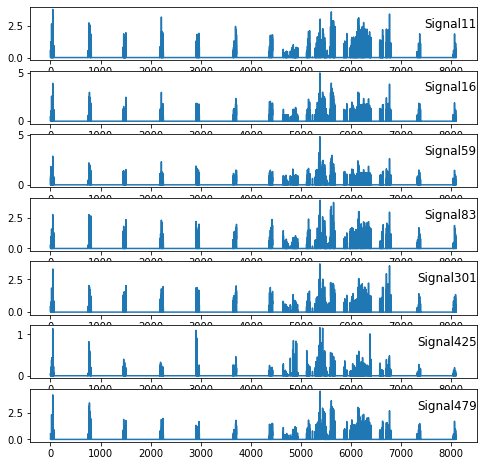

In [23]:
# Check the distribution of some variables
values = data.values

# Specify columns to plot
groups = [0, 1, 5, 10, 20, 25, 35]
i = 1
# Plot each column
plt.figure(figsize=(8,8))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

The distribution of the variables show that the most frequency of the signals occur between ~5000-7000 period, corresponding to
the time interval between August 2008 and October 2008.

Next it is defined a function "series_to_supervised" to create columns of lag observations and forecast observations.
The function basically transforms the time series from a sequence, to pairs of input and output sequences. For this it is used 
the pandas shift() function that creates copies of columns that are pushed forward or pulled back 
(adding rows of NaNs to the front or to the end). This way can be created new framings of the time series
given the desired length of input and output sequences. All variates in the time series can be shifted like this to create
multivariate input and output sequences. The function takes the arguments below and returns a single value, the pandas DataFrame
of series framed for supervised learning.
- data - sequence of observations as a list or 2D NumPy array
- n_in - number of lag observations as input (X). The values are between 1 and len(data); default is 1
- n_out - number of observations as output (y). The values are between 0 and len(data)-1; default is 1
- dropnan - Boolean whether or not to drop rows with NaN values; default is True

In [24]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Create lag and forecast observations"""
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Ensure all data is float
values = values.astype('float32')
# Frame as supervised learning
reframed = series_to_supervised(data, 1, 1)
# Display first rows
reframed.head(3)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var32(t),var33(t),var34(t),var35(t),var36(t),var37(t),var38(t),var39(t),var40(t),var41(t)
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-08 03:00:00,0.539352,0.457887,0.80188,0.716559,0.408894,0.854703,0.658615,0.298714,0.192956,0.504451,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2008-01-08 04:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2008-01-08 05:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.187537,0.07251,0.174752,0.218409,0.098701,0.493507,0.179895,0.716165,0.417188,0


In the transformed dataset the observations are named “var1” and the input observation is named (t-1) while the output time step
is named (t). There are 40 input variables (input series) and the 1 output variable (the target at the current hour).
To build the time series forecasting LSTM model, we can use the lagged observations (e.g. t-1) as input variables to forecast
the current time step (t).

We check the column names for the reframed dataset, to see which are the columns that we don't want to predict, then drop them.

In [ ]:
# Check the column names
#cols_reframed = reframed.columns
#cols_reframed

In [25]:
# Drop columns we don't want to predict
reframed.drop(reframed.columns[[40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,
                               71,72,73,74,75,76,77,78,79,80]], axis=1, inplace=True)
reframed.head(3)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var32(t-1),var33(t-1),var34(t-1),var35(t-1),var36(t-1),var37(t-1),var38(t-1),var39(t-1),var40(t-1),var41(t)
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-08 03:00:00,0.539352,0.457887,0.80188,0.716559,0.408894,0.854703,0.658615,0.298714,0.192956,0.504451,...,0.198701,0.038007,0.218997,0.152071,0.533841,0.493507,0.714518,0.499585,0.535342,0
2008-01-08 04:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2008-01-08 05:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


The dataset is split into train and test sets, then the train and test sets split into input and output variables. 
For training are used 250 days from the entire period and the rest are used for testing. Then, the inputs (X) are
reshaped into the 3D format [samples, timesteps, features] expected by LSTM model. The shape of the input and output shapes are
printed below.

In [26]:
# Get the values from reframed
values = reframed.values
# Check the shape
values.shape

(8104, 41)

In [27]:
# Split into train and test sets
n_train_hours = 250 * 24                       # use 250 days x 24 hours/day
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Print input and output shapes
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(6000, 40)
(6000,)
(2104, 40)
(2104,)


In [28]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6000, 1, 40) (6000,) (2104, 1, 40) (2104,)


The shape of the train and test input and output sets show that there are used 6000 hours of data for training and about 2000 
hours for testing.<br>
Next it is built the RNN-LSTM model. There are four LSTM layers with 50 neurons each. The first layer has the input-shape() 
argument which expects a 3D tensor with shape [samples, timesteps, features]. The return_sequences argument is set to True.
After compiling, the model is trained for 10 epochs then evaluated the accuracy score.

In [29]:
# Build the RNN-LSTM model

model_rnn = Sequential()
model_rnn.add(LSTM(units = 50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(units = 50, return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(units = 50, return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(units = 50))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units = 1))

In [30]:
# Compiling the sequential model
model_rnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Training the model
model_rnn.fit(train_X, train_y, batch_size=64, epochs=10, validation_data=(test_X, test_y))

Epoch 1/10
94/94 [==============================] - 5s 16ms/step - loss: nan - accuracy: 0.9162 - val_loss: nan - val_accuracy: 0.8394
Epoch 2/10
94/94 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.9143 - val_loss: nan - val_accuracy: 0.8394
Epoch 3/10
94/94 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9183 - val_loss: nan - val_accuracy: 0.8394
Epoch 4/10
94/94 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.9093 - val_loss: nan - val_accuracy: 0.8394
Epoch 5/10
94/94 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9139 - val_loss: nan - val_accuracy: 0.8394
Epoch 6/10
94/94 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9146 - val_loss: nan - val_accuracy: 0.8394
Epoch 7/10
94/94 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9120 - val_loss: nan - val_accuracy: 0.8394
Epoch 8/10
94/94 [==============================] - 1s 6ms/st

In [31]:
# Evaluate model
scores = model_rnn.evaluate(test_X, test_y, verbose=0)
print("Model RNN Accuracy: %.2f%%" % (scores[1]*100))

Model RNN Accuracy: 83.94%


The RNN-LSTM model achieved an accuracy score of **84%**.

In [ ]:
# Solicit Feedback - Question 1

# Is there a better way to split train and test series data for obtaining the inputs and outputs for building the RNN model? 

### 4. Summarize your findings with examples

#### Explain what the manufacturer should focus on to optimize the diaper manufacturing process.

- The SECOM dataset was **cleaned and prepared** by imputing missing values and replacing outliers. 

- To address the **class imbalance** in the label, it was applied **SMOTE technique** to do oversampling of the minority class. 

- **Feature selection** (previously done), yielded a subset of the most relevant features to the target variable. 

- The **subset of 40 features** was used for building three classification models for predicting the diaper quality: a **Multi-layer 
Neural Network perceptron classifier (MLP)**, a **Deep Neural Network (DNN)** classifier and a  **Recurrent Neural 
Networks (RNN)-Long Short-Term Memory (LSTM) model**. 

- For **modeling** the secom sequence data **as time series with multiple input variables**, the **input and output data** needed to be 
prepared to **match the input and output of the LSTM model**. Each model was evaluated by calculating the accuracy rate. 
The **highest accuracy rate** was achieved by the **DNN model** with a value of **94.3%**, followed by the MLP model with 91.3% and the 
RNN model with 84%.

The Neural network models built behave like black box algorithms, and this does not allow drawing direct recommendations for 
the diaper manufacturer regarding the sensor measurements. But, as mentioned above, only 40 features were 
selected as relevant from the initial 590 attributes for building the classification models. 

It can be concluded that multiple sensor measurements were not important in determining whether or not an anomaly is detected. 
Since sensor measurements are subject to noise or irrelevant information, when selecting a sensor, the manufacturer should 
understand the impact of each characteristic on the measurements and make sure to select a sensor that aligns closely with 
the project requirements.